In [1]:
import sys
from PIL import Image
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio

class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        label = f.split("/")[-2]
        label = 1. if label == 'pos' else 0
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device),
             "label": label}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["label"].size())

        return d

In [2]:
class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.

    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).

    patch_size : int
        Size of the patch (it is a square).

    in_chans : int
        Number of input channels.

    embed_dim : int
        The emmbedding dimension.

    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.

    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2


        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(
                x
            )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x

In [3]:
class Attention(nn.Module):
    """Attention mechanism.

    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.

    n_heads : int
        Number of attention heads.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    attn_p : float
        Dropout probability applied to the query, key and value tensors.

    proj_p : float
        Dropout probability applied to the output tensor.


    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.

    qkv : nn.Linear
        Linear projection for the query, key and value.

    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.

    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x

In [4]:
class MLP(nn.Module):
    """Multilayer perceptron.

    Parameters
    ----------
    in_features : int
        Number of input features.

    hidden_features : int
        Number of nodes in the hidden layer.

    out_features : int
        Number of output features.

    p : float
        Dropout probability.

    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.

    act : nn.GELU
        GELU activation function.

    fc2 : nn.Linear
        The second linear layer.

    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x

In [5]:
class Block(nn.Module):
    """Transformer block.

    Parameters
    ----------
    dim : int
        Embeddinig dimension.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.

    attn : Attention
        Attention module.

    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

In [6]:
class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.

    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).

    patch_size : int
        Both height and the width of the patch (it is a square).

    in_chans : int
        Number of input channels.

    n_classes : int
        Number of classes.

    embed_dim : int
        Dimensionality of the token/patch embeddings.

    depth : int
        Number of blocks.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.

    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.

    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.

    pos_drop : nn.Dropout
        Dropout layer.

    blocks : nn.ModuleList
        List of `Block` modules.

    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

In [7]:
# Current model
model = VisionTransformer(
    img_size=128,
            patch_size=8,
            in_chans=12,
            n_classes=1,
            embed_dim=128,
            depth=8,
            n_heads=8,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
)

x = torch.randn(7, 12, 128, 128) # Dummy images
out = model(x)
print(out.shape)

torch.Size([7, 1])


In [8]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path
        self.device = torch.device('cuda')

        # Training parameters
        self.opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_function = loss_function
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []
        ious = []

        outs = []
        ts = []

        def calculate_iou(pred, target):
            eps = 1e-6
            # convert to sigmoid then to binary
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["label"].to(self.device)))
#                 ious.append(calculate_iou(out, task["label"]))
                outs.append(out.detach().cpu().numpy())
                ts.append([0])

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))

        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss, mIoU

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:

                    out = self.model(task["pred"])

                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["label"].to(self.device))

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
#                 print(self.sched.get_last_lr())

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                #                 torch.save({
                #                     'epoch': epoch,
                #                     'model_state_dict': self.model.state_dict(),
                #                     'optimizer_state_dict': self.opt.state_dict(),
                #                     'loss': epoch_loss
                #                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 10 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")
    
#         np.save(self.save_path+"losses.npy", np.array(self.losses))
#         self.plot_losses()

#         torch.save({
#             # 'epoch': epoch,
#             'model_state_dict': best_model_state_dict,
#             'optimizer_state_dict': best_opt_state_dict,
#             'loss': best_loss
#         }, self.save_path+"final_model".format(epoch))

In [9]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [10]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="mean") 
    ll = bce_loss(pred, target)
    
    return ll

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training epoch 0


100%|██████████| 75/75 [00:44<00:00,  1.69batch/s, loss=0.622]


- Log loss: 0.5895377756628607
- mIoU: nan
Training epoch 1


100%|██████████| 75/75 [00:31<00:00,  2.38batch/s, loss=0.61] 


- Log loss: 0.5955209620296955
- mIoU: nan
Training epoch 2


100%|██████████| 75/75 [00:32<00:00,  2.33batch/s, loss=0.53] 


- Log loss: 0.6117210600924279
- mIoU: nan
Training epoch 3


100%|██████████| 75/75 [00:31<00:00,  2.42batch/s, loss=0.518]


- Log loss: 0.6031953324297709
- mIoU: nan
Training epoch 4


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=0.612]


- Log loss: 0.6144516176144992
- mIoU: nan
Training epoch 5


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=0.472]


- Log loss: 0.6246434165308961
- mIoU: nan
Training epoch 6


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=0.601]


- Log loss: 0.6101470347405189
- mIoU: nan
Training epoch 7


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=0.609]


- Log loss: 0.5945646495114835
- mIoU: nan
Training epoch 8


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=0.634]


- Log loss: 0.5887028160504997
- mIoU: nan
Training epoch 9


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=0.552]


- Log loss: 0.579692340449297
- mIoU: nan


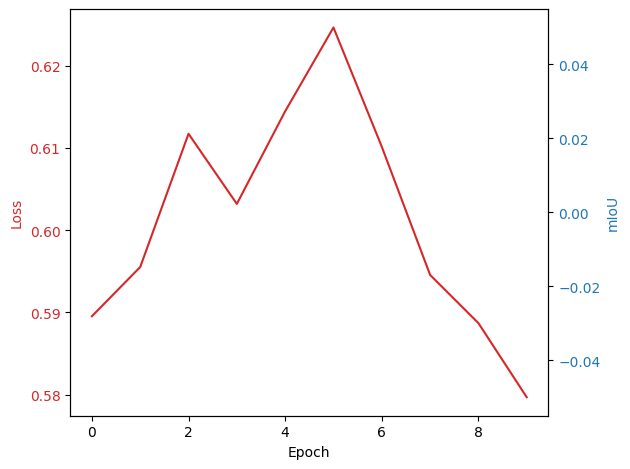

Training epoch 10


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=0.412]


- Log loss: 0.5855731860512778
- mIoU: nan
Training epoch 11


100%|██████████| 75/75 [00:25<00:00,  2.95batch/s, loss=0.437]


- Log loss: 0.5891080232614296
- mIoU: nan
Training epoch 12


100%|██████████| 75/75 [00:25<00:00,  2.91batch/s, loss=0.624]


- Log loss: 0.6112591113440603
- mIoU: nan
Training epoch 13


100%|██████████| 75/75 [00:24<00:00,  3.02batch/s, loss=0.66] 


- Log loss: 0.5667858414994995
- mIoU: nan
Training epoch 14


100%|██████████| 75/75 [00:24<00:00,  3.02batch/s, loss=0.559]


- Log loss: 0.5510671981566009
- mIoU: nan
Training epoch 15


100%|██████████| 75/75 [00:24<00:00,  3.06batch/s, loss=0.64] 


- Log loss: 0.6007242380730098
- mIoU: nan
Training epoch 16


100%|██████████| 75/75 [00:23<00:00,  3.16batch/s, loss=0.592]


- Log loss: 0.5935835522266903
- mIoU: nan
Training epoch 17


100%|██████████| 75/75 [00:23<00:00,  3.20batch/s, loss=0.466]


- Log loss: 0.594070273282982
- mIoU: nan
Training epoch 18


100%|██████████| 75/75 [00:22<00:00,  3.32batch/s, loss=0.6]  


- Log loss: 0.6655946298280642
- mIoU: nan
Training epoch 19


100%|██████████| 75/75 [00:22<00:00,  3.27batch/s, loss=0.527]


- Log loss: 0.5930547231542213
- mIoU: nan


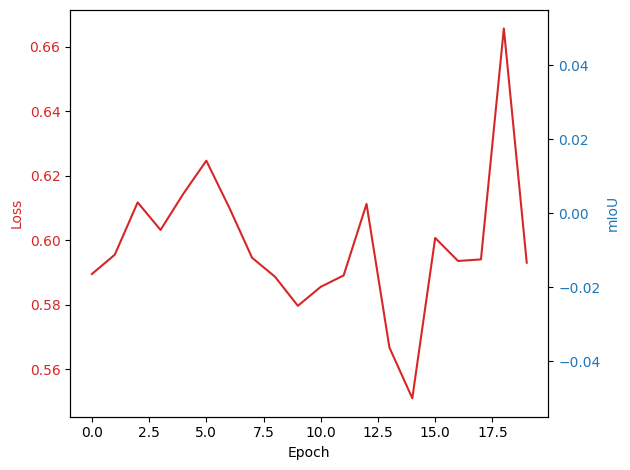

Training epoch 20


100%|██████████| 75/75 [00:23<00:00,  3.26batch/s, loss=0.448]


- Log loss: 0.5813454434098232
- mIoU: nan
Training epoch 21


100%|██████████| 75/75 [00:21<00:00,  3.42batch/s, loss=0.656]


- Log loss: 0.5811030288559518
- mIoU: nan
Training epoch 22


100%|██████████| 75/75 [00:22<00:00,  3.34batch/s, loss=0.451]


- Log loss: 0.5435729473840356
- mIoU: nan
Training epoch 23


100%|██████████| 75/75 [00:22<00:00,  3.39batch/s, loss=0.457]


- Log loss: 0.5601567522666993
- mIoU: nan
Training epoch 24


100%|██████████| 75/75 [00:22<00:00,  3.31batch/s, loss=0.708]


- Log loss: 0.5999828509454216
- mIoU: nan
Training epoch 25


100%|██████████| 75/75 [00:21<00:00,  3.41batch/s, loss=0.66] 


- Log loss: 0.5910598667471536
- mIoU: nan
Training epoch 26


100%|██████████| 75/75 [00:21<00:00,  3.42batch/s, loss=0.906]


- Log loss: 0.5697970076508465
- mIoU: nan
Training epoch 27


100%|██████████| 75/75 [00:22<00:00,  3.34batch/s, loss=0.588]


- Log loss: 0.560368236486933
- mIoU: nan
Training epoch 28


100%|██████████| 75/75 [00:22<00:00,  3.39batch/s, loss=0.592]


- Log loss: 0.5722250013146549
- mIoU: nan
Training epoch 29


100%|██████████| 75/75 [00:22<00:00,  3.39batch/s, loss=0.514]


- Log loss: 0.5420151463709771
- mIoU: nan


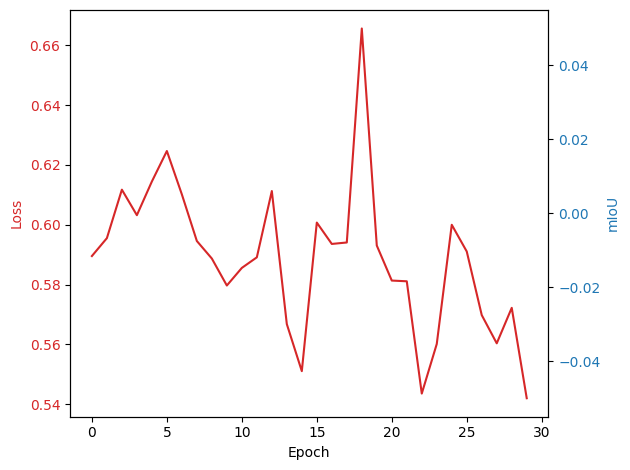

Training epoch 30


100%|██████████| 75/75 [00:21<00:00,  3.44batch/s, loss=0.668]


- Log loss: 0.6018564464258296
- mIoU: nan
Training epoch 31


100%|██████████| 75/75 [00:21<00:00,  3.46batch/s, loss=0.409]


- Log loss: 0.5489586377083989
- mIoU: nan
Training epoch 32


100%|██████████| 75/75 [00:21<00:00,  3.44batch/s, loss=0.492]


- Log loss: 0.5767881031946412
- mIoU: nan
Training epoch 33


100%|██████████| 75/75 [00:21<00:00,  3.50batch/s, loss=0.586]


- Log loss: 0.5577914017518716
- mIoU: nan
Training epoch 34


100%|██████████| 75/75 [00:21<00:00,  3.48batch/s, loss=0.962]


- Log loss: 0.5592748470870512
- mIoU: nan
Training epoch 35


100%|██████████| 75/75 [00:21<00:00,  3.47batch/s, loss=0.391]


- Log loss: 0.5395437184011652
- mIoU: nan
Training epoch 36


100%|██████████| 75/75 [00:21<00:00,  3.52batch/s, loss=0.581]


- Log loss: 0.5598278358135195
- mIoU: nan
Training epoch 37


100%|██████████| 75/75 [00:21<00:00,  3.50batch/s, loss=0.568]


- Log loss: 0.5589452531432644
- mIoU: nan
Training epoch 38


100%|██████████| 75/75 [00:21<00:00,  3.52batch/s, loss=0.255]


- Log loss: 0.5561589385770882
- mIoU: nan
Training epoch 39


100%|██████████| 75/75 [00:21<00:00,  3.51batch/s, loss=0.403]


- Log loss: 0.5577247590181373
- mIoU: nan


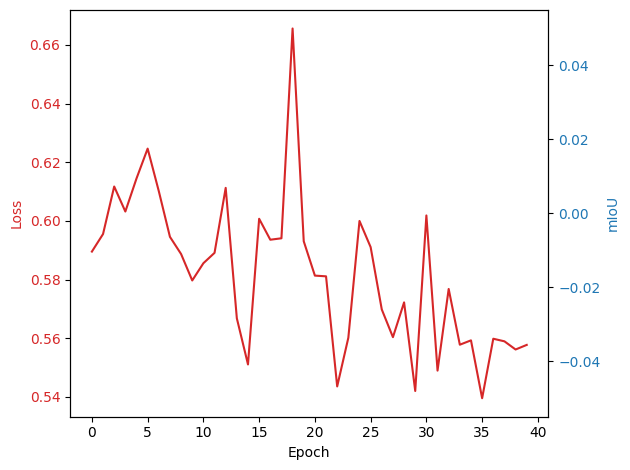

Training epoch 40


100%|██████████| 75/75 [00:21<00:00,  3.55batch/s, loss=0.664]


- Log loss: 0.5298228512285277
- mIoU: nan
Training epoch 41


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=0.794]


- Log loss: 0.5488536799359801
- mIoU: nan
Training epoch 42


100%|██████████| 75/75 [00:21<00:00,  3.49batch/s, loss=0.544]


- Log loss: 0.5309338849170931
- mIoU: nan
Training epoch 43


100%|██████████| 75/75 [00:21<00:00,  3.50batch/s, loss=0.559]


- Log loss: 0.5539080456331639
- mIoU: nan
Training epoch 44


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=0.413]


- Log loss: 0.5678465068573132
- mIoU: nan
Training epoch 45


100%|██████████| 75/75 [00:21<00:00,  3.54batch/s, loss=0.659]


- Log loss: 0.5423615195023428
- mIoU: nan
Training epoch 46


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=0.431]


- Log loss: 0.5251960678713484
- mIoU: nan
Training epoch 47


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.477]


- Log loss: 0.5302970805704328
- mIoU: nan
Training epoch 48


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.298]


- Log loss: 0.5466492710102882
- mIoU: nan
Training epoch 49


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=0.632]


- Log loss: 0.5486206552279848
- mIoU: nan


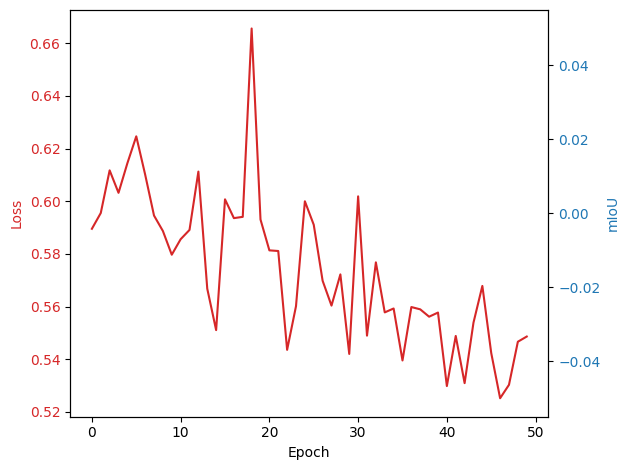

Training epoch 50


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=0.583]


- Log loss: 0.5287254437294212
- mIoU: nan
Training epoch 51


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=0.557]


- Log loss: 0.5377038081974855
- mIoU: nan
Training epoch 52


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.645]


- Log loss: 0.5177273288790492
- mIoU: nan
Training epoch 53


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.313]


- Log loss: 0.5178901051348518
- mIoU: nan
Training epoch 54


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=0.528]


- Log loss: 0.5301938496263964
- mIoU: nan
Training epoch 55


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.675]


- Log loss: 0.5600408328630563
- mIoU: nan
Training epoch 56


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=0.675]


- Log loss: 0.5357457123364189
- mIoU: nan
Training epoch 57


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=0.605]


- Log loss: 0.5222945154844117
- mIoU: nan
Training epoch 58


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=0.407]


- Log loss: 0.5349623228766999
- mIoU: nan
Training epoch 59


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=0.412]


- Log loss: 0.5487924943345466
- mIoU: nan


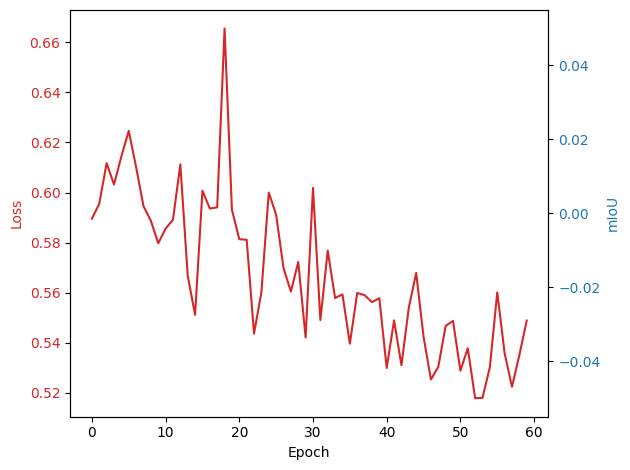

Training epoch 60


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=0.544]


- Log loss: 0.5306096346782786
- mIoU: nan
Training epoch 61


100%|██████████| 75/75 [00:20<00:00,  3.58batch/s, loss=0.429]


- Log loss: 0.5211269963155722
- mIoU: nan
Training epoch 62


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=0.662]


- Log loss: 0.5516241531375617
- mIoU: nan
Training epoch 63


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=0.34] 


- Log loss: 0.5318044718177545
- mIoU: nan
Training epoch 64


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=0.357]


- Log loss: 0.5242335958938513
- mIoU: nan
Training epoch 65


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.388]


- Log loss: 0.5747519127558917
- mIoU: nan
Training epoch 66


100%|██████████| 75/75 [00:20<00:00,  3.57batch/s, loss=0.388]


- Log loss: 0.5403409023004185
- mIoU: nan
Training epoch 67


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=0.406]


- Log loss: 0.5342042831504451
- mIoU: nan
Training epoch 68


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.357]


- Log loss: 0.5263124465454546
- mIoU: nan
Training epoch 69


100%|██████████| 75/75 [00:21<00:00,  3.55batch/s, loss=0.497]


- Log loss: 0.5282703743482541
- mIoU: nan


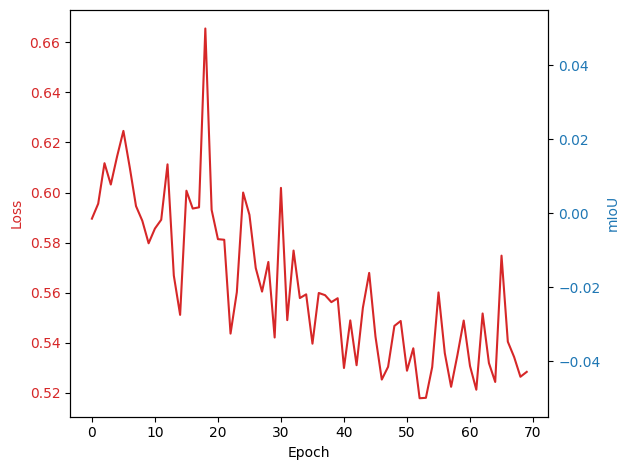

Training epoch 70


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=0.486]


- Log loss: 0.5283859441101195
- mIoU: nan
Training epoch 71


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=0.483]


- Log loss: 0.5200343106163754
- mIoU: nan
Training epoch 72


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=0.59] 


- Log loss: 0.5267361774974103
- mIoU: nan
Training epoch 73


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=0.362]


- Log loss: 0.5351125217308955
- mIoU: nan
Training epoch 74


100%|██████████| 75/75 [00:21<00:00,  3.56batch/s, loss=0.406]


- Log loss: 0.5279279410706035
- mIoU: nan
Training epoch 75


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=0.674]


- Log loss: 0.5534967126324772
- mIoU: nan
Training epoch 76


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.301]


- Log loss: 0.5499912535804989
- mIoU: nan
Training epoch 77


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.437]


- Log loss: 0.5239120986356975
- mIoU: nan
Training epoch 78


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=0.46] 


- Log loss: 0.5154525274710198
- mIoU: nan
Training epoch 79


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=0.346]


- Log loss: 0.514639978354708
- mIoU: nan


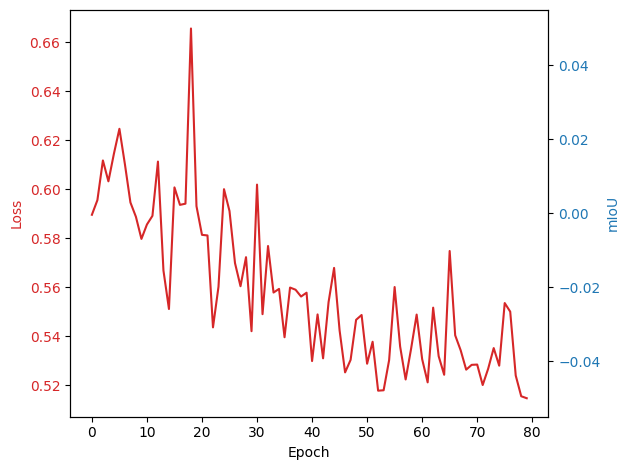

Training epoch 80


100%|██████████| 75/75 [00:21<00:00,  3.57batch/s, loss=0.206]


- Log loss: 0.5350276699600119
- mIoU: nan
Training epoch 81


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.39] 


- Log loss: 0.5217076473891558
- mIoU: nan
Training epoch 82


100%|██████████| 75/75 [00:20<00:00,  3.64batch/s, loss=0.367]


- Log loss: 0.5295962187661124
- mIoU: nan
Training epoch 83


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.589]


- Log loss: 0.5363354284815224
- mIoU: nan
Training epoch 84


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.58] 


- Log loss: 0.541791744463678
- mIoU: nan
Training epoch 85


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=0.299]


- Log loss: 0.5340048281509163
- mIoU: nan
Training epoch 86


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=0.312]


- Log loss: 0.5507780295752344
- mIoU: nan
Training epoch 87


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=0.516]


- Log loss: 0.5151801305335192
- mIoU: nan
Training epoch 88


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=0.317]


- Log loss: 0.5338306375712688
- mIoU: nan
Training epoch 89


100%|██████████| 75/75 [00:20<00:00,  3.70batch/s, loss=0.406]


- Log loss: 0.5338265259351049
- mIoU: nan


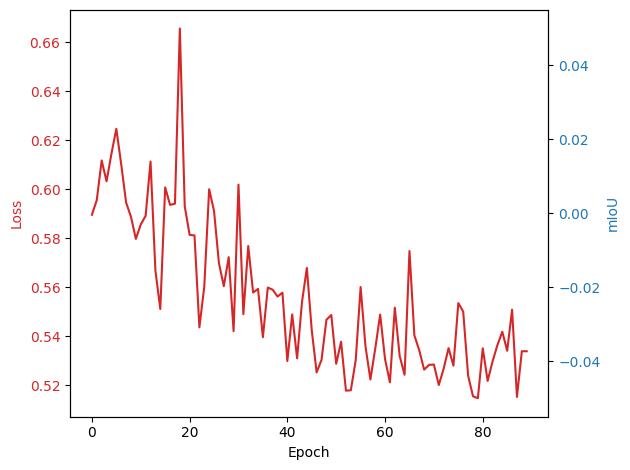

Training epoch 90


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=0.568]


- Log loss: 0.5307696272286453
- mIoU: nan
Training epoch 91


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=0.629]


- Log loss: 0.5203452062626769
- mIoU: nan
Training epoch 92


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=0.375]


- Log loss: 0.5283657990229715
- mIoU: nan
Training epoch 93


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=0.409]


- Log loss: 0.5265625422886971
- mIoU: nan
Training epoch 94


100%|██████████| 75/75 [00:20<00:00,  3.58batch/s, loss=0.133]


- Log loss: 0.5247900810558349
- mIoU: nan
Training epoch 95


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=0.461]


- Log loss: 0.5254587289422662
- mIoU: nan
Training epoch 96


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=0.446]


- Log loss: 0.5276369124285079
- mIoU: nan
Training epoch 97


100%|██████████| 75/75 [00:20<00:00,  3.63batch/s, loss=0.495]


- Log loss: 0.5373843297983208
- mIoU: nan
Training epoch 98


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=0.41] 


- Log loss: 0.5326318797721926
- mIoU: nan
Training epoch 99


100%|██████████| 75/75 [00:20<00:00,  3.65batch/s, loss=0.329]


- Log loss: 0.5287138220011478
- mIoU: nan


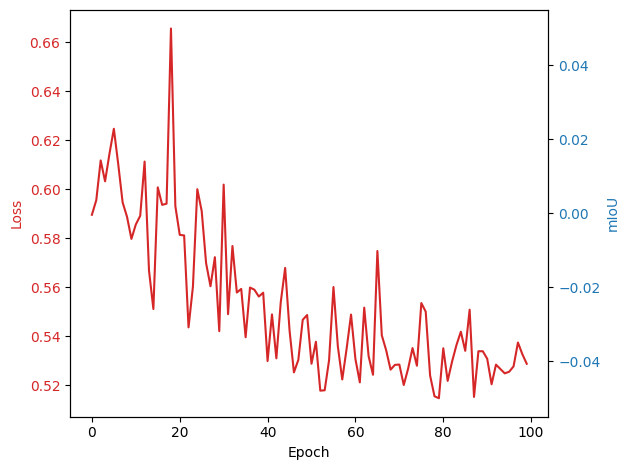

Training complete!


In [11]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys
import heapq


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = VisionTransformer(
    img_size=128,
            patch_size=8,
            in_chans=12,
            n_classes=1,
            embed_dim=128,
            depth=8,
            n_heads=8,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
# loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])
loss_fn = loss

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,                     
                  loss_fn,
                  out_dir,
                  1.5e-4)

# Train
trainer.train(n_epochs=100)

In [12]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [13]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [14]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = VisionTransformer(
    img_size=128,
            patch_size=8,
            in_chans=12,
            n_classes=1,
            embed_dim=128,
            depth=8,
            n_heads=8,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()

Loading losses...
best epoch:  79


/tmp/ipykernel_30/4105568515.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(in_dir+"final_model",


DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(12, 128, kernel_size=(8, 8), stride=(8, 8))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-7): 8 x Block(
        (norm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=128, out_features=512, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=512, out_features=128, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((128,), eps=1e-06, elementwise_affi

In [15]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred[0])).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out[0]).cpu())
        targets.append(np.squeeze(batch["label"]).cpu())
        loss_val = loss_fn(np.squeeze(out).unsqueeze(0), np.squeeze(d3).unsqueeze(0), np.squeeze(d4).unsqueeze(0), np.squeeze(d5).unsqueeze(0), np.squeeze(batch["label"]).unsqueeze(0))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

  0%|          | 0/250 [00:00<?, ?it/s]


NameError: name 'd3' is not defined

In [ ]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==20): break
